In [1]:
import time

import numpy as np

from mindspore import context, nn, Tensor, ops, jit, set_seed, data_sink
from mindspore import dtype as mstype
from sympy import Function, symbols, sin, cos, pi
from mindflow.utils import load_yaml_config
from mindflow.cell import FCSequential
from mindflow.pde import PDEWithLoss, sympy_to_mindspore


from src import create_training_dataset, create_test_dataset
from src import calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [2]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config("configs/darcy.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

In [3]:
# create train dataset
geom_name = "flow_region"
flow_train_dataset = create_training_dataset(config, geom_name)
train_data = flow_train_dataset.create_dataset(
    batch_size=config["data"]["train"]["batch_size"], shuffle=True, drop_remainder=True
)

# create test dataset
test_input, test_label = create_test_dataset(config)

In [4]:
# network model
model = FCSequential(in_channels=config["model"]["in_channels"],
                     out_channels=config["model"]["out_channels"],
                     neurons=config["model"]["neurons"],
                     layers=config["model"]["layers"],
                     residual=config["model"]["residual"],
                     act=config["model"]["activation"],
                     weight_init=config["model"]["weight_init"])

In [5]:
# optimizer
params = model.trainable_params()
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["learning_rate"])

In [6]:
class Darcy2D(PDEWithLoss):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        self.x, self.y = symbols("x y")
        self.u = Function("u")(self.x, self.y)
        self.v = Function("v")(self.x, self.y)
        self.p = Function("p")(self.x, self.y)
        self.in_vars = [self.x, self.y]
        self.out_vars = [self.u, self.v, self.p]
        self.loss_fn = loss_fn
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)
        super(Darcy2D, self).__init__(model, self.in_vars, self.out_vars)

    def force_function(self, x, y):
        return 8 * pi**2 * sin(2 * pi * x) * cos(2 * pi * y)

    def pde(self):
        loss_1 = (
            self.u.diff(self.x)
            + self.v.diff(self.y)
            - self.force_function(self.x, self.y)
        )
        loss_2 = self.u + self.p.diff(self.x)
        loss_3 = self.v + self.p.diff(self.y)
        return {"loss_1": loss_1, "loss_2": loss_2, "loss_3": loss_3}

    def bc(self):
        u_boundary = self.u - (-2 * pi * cos(2 * pi * self.x) * cos(2 * pi * self.y))

        v_boundary = self.v - (2 * pi * sin(2 * pi * self.x) * sin(2 * pi * self.y))

        p_boundary = self.p - (sin(2 * pi * self.x) * cos(2 * pi * self.y))

        return {
            "u_boundary": u_boundary,
            "v_boundary": v_boundary,
            "p_boundary": p_boundary,
        }

    def get_loss(self, pde_data, bc_data):
        pde_res = ops.Concat(1)(self.parse_node(self.pde_nodes, inputs=pde_data))
        pde_loss = self.loss_fn(
            pde_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        bc_res = ops.Concat(1)(self.parse_node(self.bc_nodes, inputs=bc_data))
        bc_loss = self.loss_fn(
            bc_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        return pde_loss + bc_loss

In [10]:
import mindspore
from mindspore import load_checkpoint

ckpt_file_name = 'darcy2D.ckpt'
param_dict = load_checkpoint(ckpt_file_name)
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load)

[WARNING] ME(44422:140224702969664,MainProcess):2024-06-12-15:26:36.133.319 [mindspore/train/serialization.py:1469] For 'load_param_into_net', remove parameter prefix name: net.network., continue to load.


[]


[0.00986522 0.00929576 0.0089671  ... 0.0023005  0.0028984  0.00355126]
[[-6.35858202e+00 -1.57695562e-02  9.86522436e-03]
 [-6.29645061e+00 -2.47522742e-02  9.29576159e-03]
 [-6.22676611e+00 -3.25473100e-02  8.96710157e-03]
 ...
 [-6.24353504e+00 -8.12832266e-02  2.30050087e-03]
 [-6.30103397e+00 -7.22693354e-02  2.89839506e-03]
 [-6.33902311e+00 -6.12837225e-02  3.55125964e-03]]


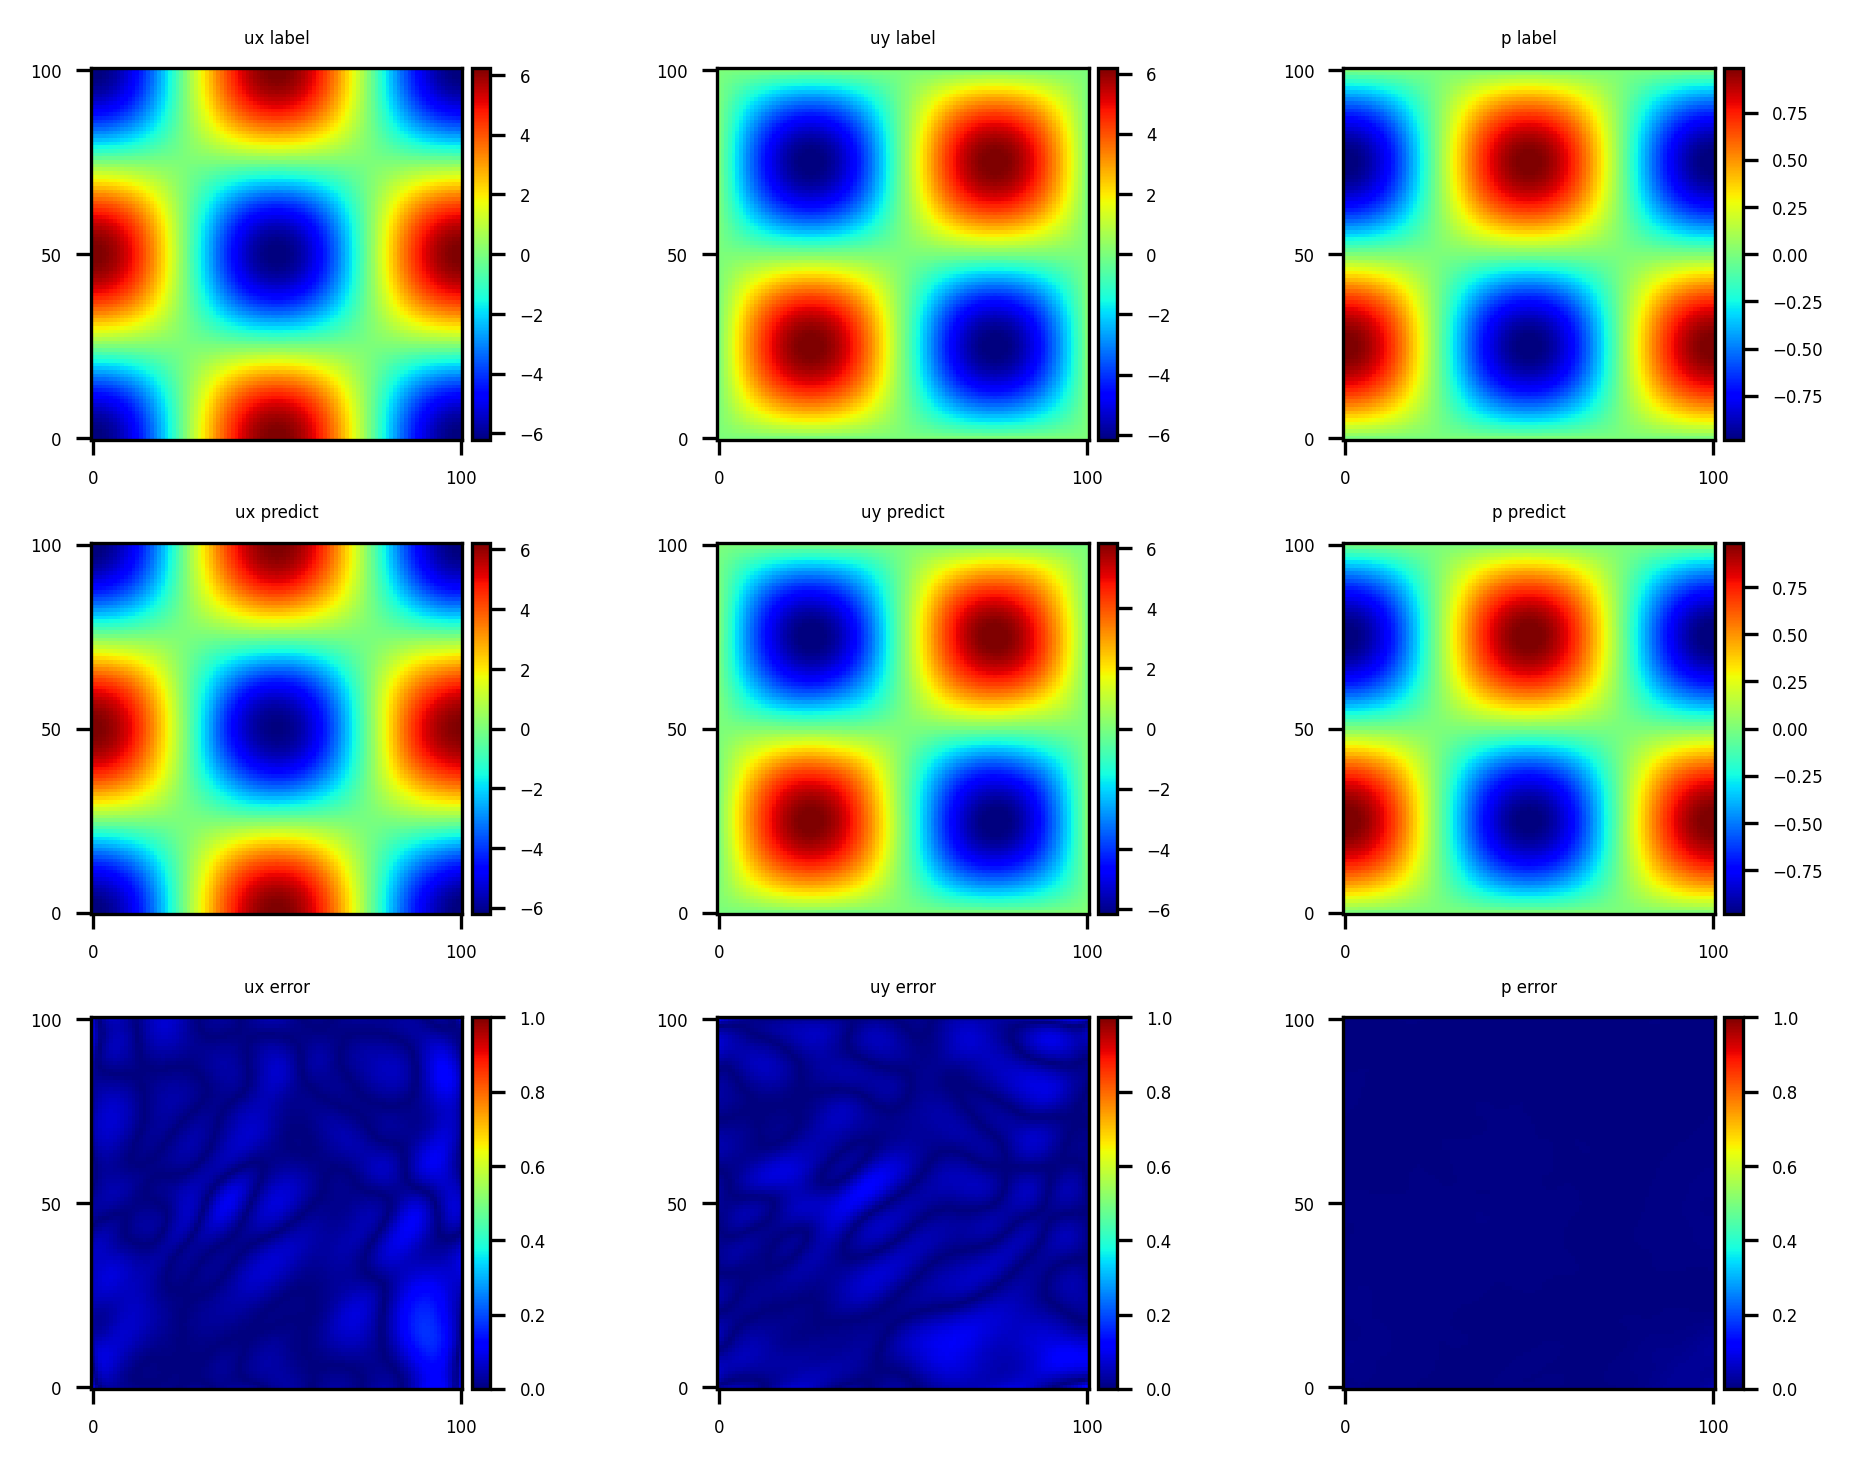

In [11]:
from src import visual
predict = visual(model, config)
print(predict)